# imports

In [1]:
%matplotlib inline
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

# Notes

    TODO: create new fits files for IV with Andrey files to see if C_A becomes 1. Expect 0.5
    
    General notes
    -------------
    
    z = 0.076 --> estimated to be about 2.23 billion light-years away. Relatively close for a GRB ... See paper for details
    
    
    
    ANDREY
    -----------
    > C_A ~0.47->0.55
    > used bak found in main trigger
    
    > LC from Andrey seems completly different that the LC from David. Which one in more correct?
    Have to again with the FERMI LC
    > T0 seems to be centered around the precoursor
    > Getting a constant factor of 0.5 for all four new intervals
    > Using bak in original trigger file >> 50% less mean counts than old bak file
    > 133 mean counts for IV1 (interval)
    > 121 mean counts for (bakground)
    
    
    DAVID
    -----------
    > C_A ~1.14
    > used bak acc. ~80 s before (?) 302 mean counts for bak
    >333 mean counts for T0+5.9->T06.5
    
    
    >> swapped bak file but didn't change constant factor. Better fit with Andrey (trigger file)
    
    
    LC ANALYSIS
    -----------
    - The main burst in ASIM seems to be highly correlated with the first peak in FERMI data    
    - tlagg = +1.792s (aligning first spike)
    - labeled the 5 intervals for spectrum acc. See MM drawing
    
    

    XSPEC ANALYSIS
    --------------
    
    Joint fit model for the various intervals varies in quality (see Excel).
    must find reason for the bad Chi^2 and constant factor.
    
    --> Calibration coefs correct? NO! Fixed
    --> Extracting correct FERMI interval? --> Generate new files!
    --> Correct background for ASIM? YES!
    --> Slight improvement after generating new fits files for ASIM
    
    
    Might try with a Band + BB model for the fit.
        

In [2]:
binsize = 0.064 #s
bins = np.arange(-0.5,8 + binsize,binsize)

# David data

In [13]:
df_david = harvest_data(fn='2021_12_11_13_10_0.mat',T0='2021-12-11T13:10:00.000')
df_david.sort_values(by="tus",inplace=True,ignore_index=True)
#df_david = df_david.truncate(after=np.searchsorted(df_andrey["tus"].to_numpy(),80.0))
T0=datetime.fromisoformat('2021-12-11T13:10:00.000')
df_david

dau/det starting from index 1
tus array given in seconds
safety time:  6.851 % removed
sorted by tus (s)


,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
0,82,2,2,2021-12-11 13:10:00.283993139,0.283993,5,1092.9790,4.309930,0.000,False
1,1666,2,2,2021-12-11 13:10:00.284209694,0.284210,5,31343.0261,23.537210,216.555,False
2,629,1,1,2021-12-11 13:10:00.284209833,0.284210,1,7317.3959,21.000000,0.000,False
3,1300,4,2,2021-12-11 13:10:00.284369694,0.284370,11,24391.2908,22.513033,159.861,False
4,177,1,1,2021-12-11 13:10:00.286609250,0.286609,1,1685.5238,6.656127,2399.417,False
...,...,...,...,...,...,...,...,...,...,...
114301,58,4,2,2021-12-11 13:10:21.232175250,21.232175,11,939.1165,0.878233,2571.222,False
114302,53,1,1,2021-12-11 13:10:21.232336389,21.232336,1,515.4016,1.061606,1477.806,False
114303,1601,4,2,2021-12-11 13:10:21.232338139,21.232338,11,30556.1127,23.444891,162.889,False
114304,336,4,3,2021-12-11 13:10:21.232338278,21.232338,12,4873.7153,14.494862,3512.611,False


# Andrey data

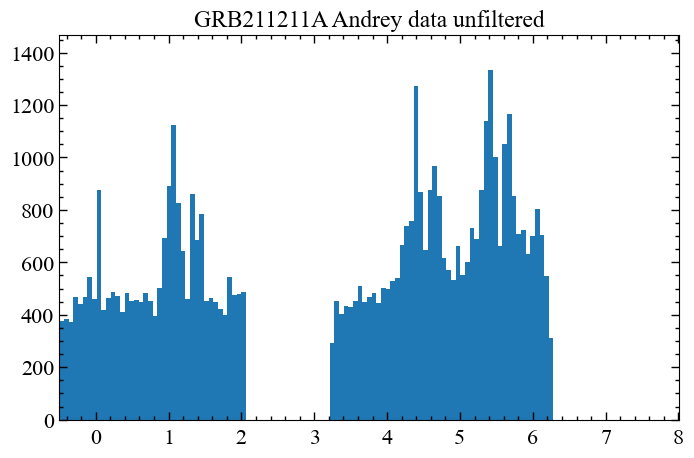

In [3]:
df_andrey = pd.read_csv(mat_path_andrey+'GRB211211A.csv') #tus given in us
df_andrey.sort_values(by="tus",inplace=True,ignore_index=True)

df_andrey['tus'] /= 1e6 #converting to s
df_andrey = df_andrey.truncate(after=np.searchsorted(df_andrey["tus"].to_numpy(),8.0))
tus_andrey = df_andrey['tus'].to_numpy(dtype=np.float64)

plt.hist(tus_andrey,bins=bins)
plt.title("GRB211211A Andrey data unfiltered")
plt.show()

In [4]:
T0 = datetime.fromisoformat('2021-12-11T13:10:01.323') #NOT CORRECT + timedelta(seconds=tlagg) #should check corrected_level1
df_andrey = make_adr(df_andrey)
df_andrey.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_andrey.drop(df_andrey[df_andrey['typ']==3].index, inplace = True) #removed valleys
df_andrey

,tus,dau,det,typ,erg,adr
0,-0.959784,1,1,0,629,1
1,-0.957384,1,1,0,177,1
2,-0.955991,1,1,0,1305,1
3,-0.954583,1,1,0,30,1
4,-0.953928,1,1,0,896,1
...,...,...,...,...,...,...
57212,6.250417,4,3,0,74,12
57213,6.251545,4,3,0,92,12
57214,6.253359,4,3,0,38,12
57215,6.255950,4,3,0,112,12


In [5]:
#ENERGY CALIBRATION
df_andrey['tus'] *= 1e6 #converting to us
tus_andrey,erg,dau,det = df_andrey['tus'].to_numpy(dtype=np.float64),df_andrey['erg'].to_numpy(),df_andrey['dau'].to_numpy(),df_andrey['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0)
df_andrey['keV'] = keV

#SAFETY TIME
st,dt = get_st(df_andrey),get_dt(df_andrey) #st returned in us
df_andrey['st']=st
df_andrey['dt']=dt

flag = get_flag(df_andrey)
df_andrey['flag'] = flag
df_andrey.drop(df_andrey[get_flag(df_andrey)].index,inplace=True)
df_andrey.sort_values(by='tus',inplace=True,ignore_index=True)
df_andrey['tus'] /= 1e6
df_andrey = df_andrey.drop(index=df_andrey.index[-1])

print('Safety time: ',np.round(np.count_nonzero(flag)/len(flag),3)*100, '% removed')
print('sorted by tus (s)')

Safety time:  0.8 % removed
sorted by tus (s)


In [6]:
df_andrey

,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-0.959784,1,1,0,629,1,7317.3959,21.000000,0.0,False
1,-0.959784,2,2,0,1666,5,31343.0261,23.537210,216.0,False
2,-0.959624,4,2,0,1300,11,24391.2908,22.513033,160.0,False
3,-0.957384,1,1,0,177,1,1685.5238,6.656127,2400.0,False
4,-0.956934,4,2,0,110,11,1856.9034,4.427614,2690.0,False
...,...,...,...,...,...,...,...,...,...,...
56435,6.258732,1,1,0,21,1,239.6375,0.000000,385.0,False
56436,6.259236,4,1,0,84,10,1232.7258,3.620602,934.0,False
56437,6.259597,1,1,0,436,1,4650.2546,16.202036,865.0,False
56438,6.259632,2,1,0,1722,4,31036.4180,25.414568,2569.0,False


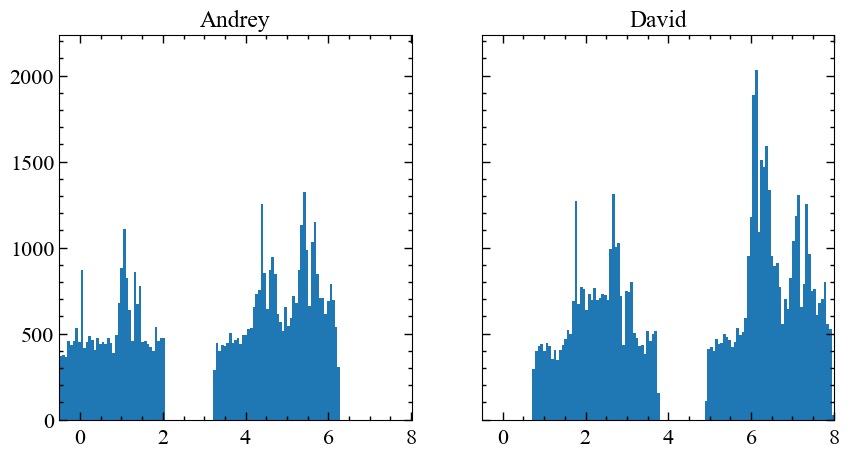

In [30]:
tus_andrey = df_andrey['tus'].to_numpy()
tus_david = df_david['tus'].to_numpy()
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})

# Plot the histograms on the subplots
axs[0].hist(tus_andrey, bins=bins)
axs[1].hist(tus_david, bins=bins)

# Set the labels for the subplots and the overall title
axs[0].set_title('Andrey')
axs[1].set_title('David')

# Display the figure
plt.show()


## Andrey data seems legit
    using andrey data 

In [7]:
asim_tus = tus_andrey
df_asim = df_andrey

In [14]:
asim_tus = df_david['tus'].to_numpy()
df_asim = df_david

### Truncating ASIM df --> bkg

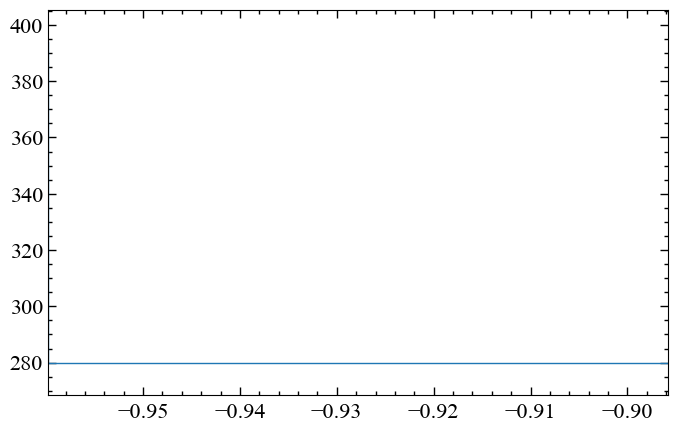

337.0 cts/0.064 s
background countrate 6263.3002


In [8]:
j = np.searchsorted(asim_tus,-0.2)
df_asim_bkg = df_asim.truncate(after=j)
df_asim = df_asim.truncate(before=j+1)
asim_tus_bkg = df_asim_bkg["tus"].to_numpy()

hist_bkg = np.histogram(asim_tus_bkg,bins=np.arange(min(asim_tus_bkg),max(asim_tus_bkg)+binsize, binsize))
bkg_counts,bkg_edges = hist_bkg[0],hist_bkg[1]

plt.step(x=bkg_edges[:-1],y=bkg_counts)
plt.show()
bkg = np.mean(bkg_counts)
print(f'{round(bkg,3)} cts/{binsize} s')
print(f'background countrate {round(len(asim_tus_bkg)/(asim_tus_bkg[-1]-asim_tus_bkg[0]),4)}')

## fermi data

In [151]:
GRB_id = "GRB211211A"
bn='bn211211549' #what is this? GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)

# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 212.271, 27.883  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn211211549_v01.fit
660921004.65092
['n2', 'na']
n2 28.936
na 49.853
n1 73.267
n5 75.59
b0 78.593
n9 84.886
n0 94.495
b1 101.407
nb 104.726
n3 128.519
n6 128.828
n4 130.308
n7 145.304
n8 149.746


In [152]:
unit = all_dets[idx_sort_angsep][1] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v02.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

na


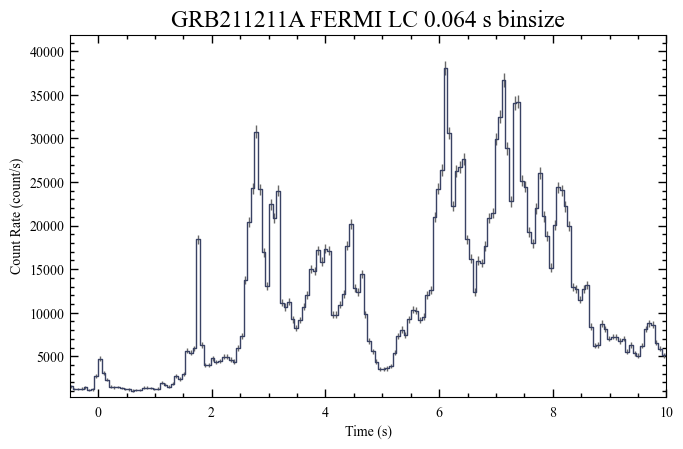

In [153]:
# open a TTE file
binsize=0.064

tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)

#phaii = tte.to_phaii(bin_by_time, binsize, time_ref=0.0)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (8,1e3) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,10)
lcplot.ax.set_title(f'GRB211211A FERMI LC {binsize} s binsize')
plt.show()

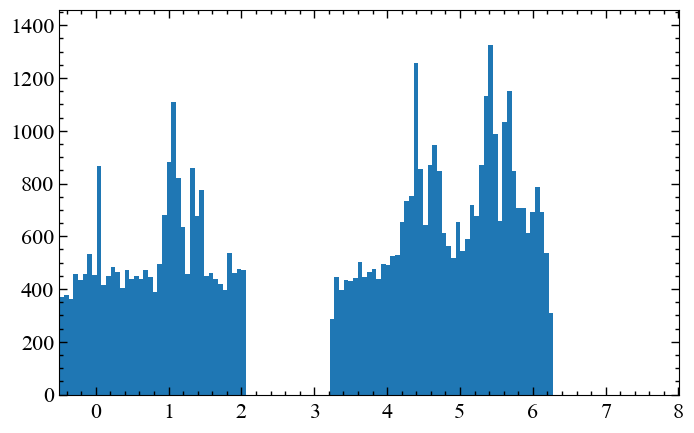

In [11]:
tus_andrey = df_andrey['tus'].to_numpy()
plt.hist(tus_andrey,bins=bins)
#plt.hist(tus_david,bins=bins)
plt.show()

In [12]:
#truncating fermi tus
tus_fermi = tte.data.time
ix,jx = np.searchsorted(tus_fermi,-0.5), np.searchsorted(tus_fermi,10)
tus_fermi = tus_fermi[ix:jx]

# super plots
    -asim_tus already shifted by tlagg
    -fermi lc is the the 350-1e5 keV band

In [ ]:
import roman
plt.figure(figsize=(14, 8))

plt.step(x=fermi_edges[:-1],y=fermi_counts/max(fermi_counts),color='black',label='FERMI, inc. bkg',where='post')
plt.step(x=asim_edges[:-1],y=asim_counts/max(asim_counts),color='red',label='ASIM, inc bkg',where='post')
plt.title('GRB211211A')
plt.xlabel(f'T-T0, {binsize} s binsize')
plt.ylabel(f'Normalized counts / {binsize} s')

#TODO: split the old interval IV and V into two each
P = [[1.5, 2.5],
     [2.5, 3.5], 
     [3.5, 4.5], 
     [5.5, 6.5],
     [6.8, 7.25]]

colors = ['black','red','green','blue', 'cyan', 'purple','red','orange']

for i, p in enumerate(P):
    plt.vlines(x=p, ymin=0,ymax=1.1, color=colors[i], alpha=0.9, linestyle= "--", label=f' Interval {roman.toRoman(i+1)} ')
    plt.text( ((p[1]+p[0]) / 2) - 0.1, 1.05, roman.toRoman(i+1), fontsize=16, c= "blue")


plt.ylim(bottom=0,top=1.2)
#plt.grid()
plt.legend()
#plt.savefig('/Home/siv30/wad005/master/GRB/pyplots/GRB211211A_correlated_intervals.png')
plt.show()

# cross correlation

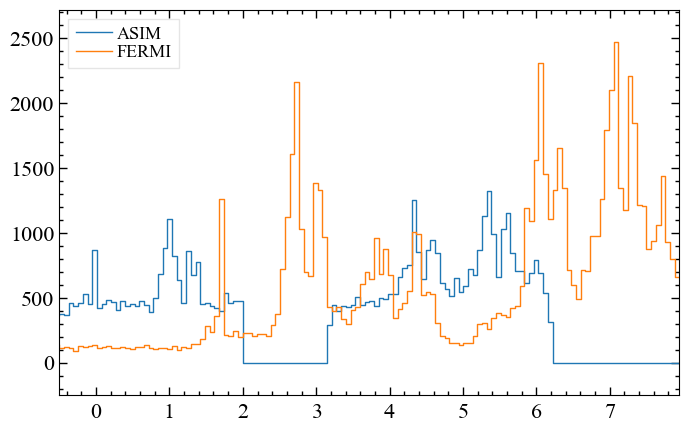

In [13]:
asim_counts,asim_edges = np.histogram(df_asim['tus'].to_numpy(dtype=np.float64),bins=bins)
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)

plt.step(x=asim_edges[:-1],y=asim_counts,label="ASIM")
plt.step(x=fermi_edges[:-1],y=fermi_counts,label="FERMI")
plt.legend()
plt.show()

In [14]:
asim_lc = LC(time=asim_edges[:-1],counts=asim_counts,dt=binsize)
fermi_lc = LC(time=fermi_edges[:-1],counts=fermi_counts,dt=binsize)

cc = CC(fermi_lc,asim_lc,mode='full')
tlagg=cc.time_shift
print("Total lagg (s): ", tlagg)

df_asim['tus']+=tlagg
#df_asim_bkg['tus']+=tlagg
asim_tus = df_asim['tus'].to_numpy()
T0 += timedelta(seconds=tlagg)
asim_hist_shift = np.histogram(asim_tus,bins=bins)
asim_counts,asim_edges = asim_hist_shift[0],asim_hist_shift[1]
print('tlagg applied to df_asim, df_bkg and T0')

Total lagg (s):  1.728
tlagg applied to df_asim, df_bkg and T0


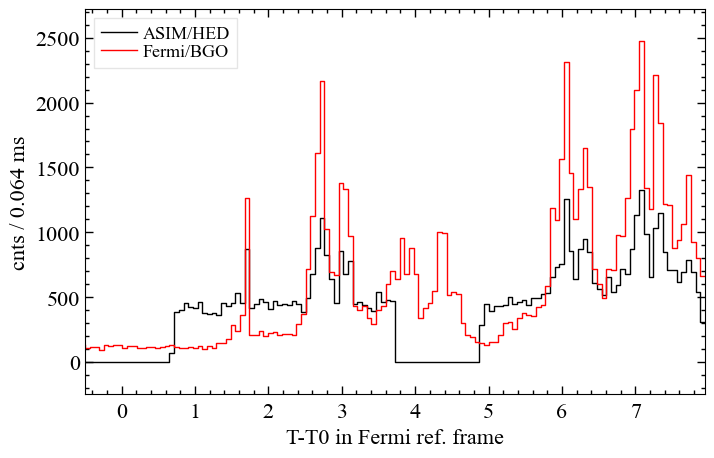

In [15]:
plt.step(x=asim_edges[:-1],y=asim_counts,label="ASIM/HED",where='pre',color='black')
plt.step(x=fermi_edges[:-1],y=fermi_counts,label="Fermi/BGO",where='pre',color='red')
plt.legend()
plt.ylabel('cnts / 0.064 ms')
plt.xlabel('T-T0 in Fermi ref. frame')
plt.savefig('GRB211211A_superLC.pdf',dpi=1000,format='pdf')
plt.show()

In [16]:
import math

I = [(bins[99],bins[104]),
    (bins[105],bins[108]),
    (bins[115],bins[120]),
    (bins[121],bins[125])] 

# Define the interval size in seconds
interval_size = 0.064

# Round the start and end times of each interval to the nearest multiple of the interval size
I_rounded = [(round(math.floor(b[0]/interval_size)*interval_size,4), round(math.ceil(b[1]/interval_size)*interval_size,4)) for b in I]
print(I_rounded)

[(5.824, 6.208), (6.208, 6.464), (6.848, 7.232), (7.232, 7.552)]


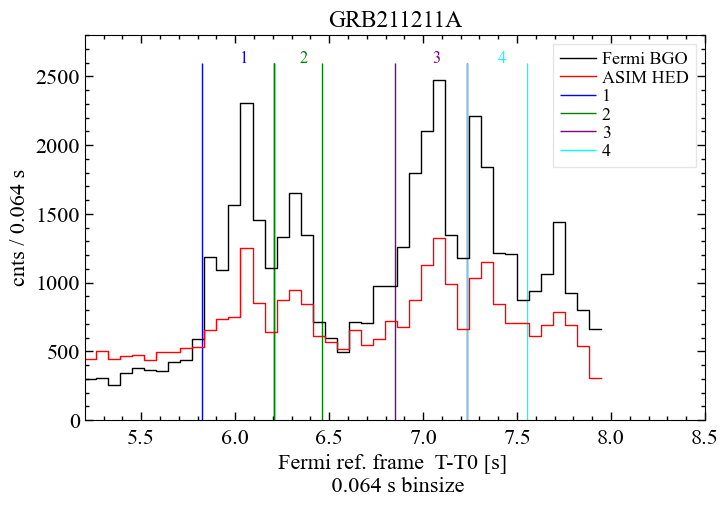

In [17]:
plt.step(x=fermi_edges[:-1],y=fermi_counts,color='black',label='Fermi BGO',where="pre")
plt.step(x=asim_edges[:-1],y=asim_counts,color='red',label='ASIM HED',where="pre")
plt.title(f'GRB211211A')
plt.xlabel(f'Fermi ref. frame  T-T0 [s] \n {binsize} s binsize')
plt.ylabel(f'cnts / {binsize} s')

plt.ylim(bottom=0,top=2800)

# Add vertical lines for each interval and label with interval string
colors = ['blue', 'green', 'purple', 'cyan']
labels = ['1', '2', '3', '4']
text_offset = 0.00  # adjust this value to control the offset of the interval text
for i, interval in enumerate(I_rounded):
    color = colors[i % len(colors)]
    plt.vlines(x=interval[0], ymin=0, ymax=2600, color=color)
    plt.vlines(x=interval[1], ymin=0, ymax=2600, color=color, label=labels[i])
    text_x = ((interval[0] + interval[1]) / 2)+0.03
    text_y = 2600+text_offset
    ha = 'center'
    if text_x < 5.2:
        ha = 'left'
        text_x += 10.5
    elif text_x > 7.6:
        ha = 'right'
        text_x -= 10.09
    plt.text(text_x, text_y, f"{labels[i]}", fontsize=12, color=color, ha=ha)

plt.legend()
plt.xlim(left=5.2,right=8.5)
plt.savefig('ASIM_FERMI_1_4_intervals.pdf',dpi=350,format='pdf')
plt.show()

### cc results

# Extraction of FITS files

## ASIM extraction

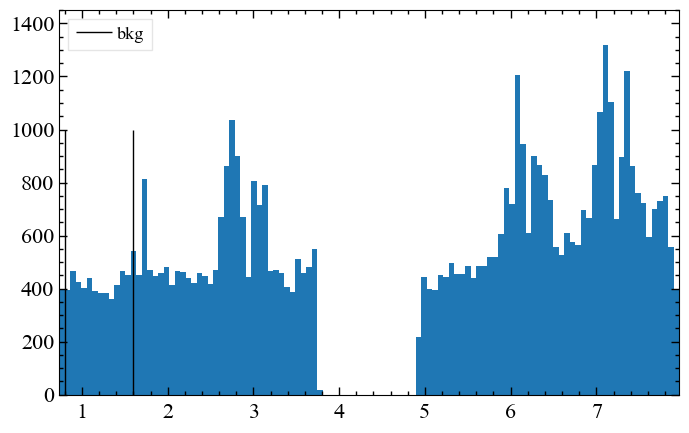

In [21]:
#background
tus = df_asim['tus'].to_numpy()
plt.hist(tus,np.arange(min(tus),max(tus)+binsize,binsize),align='left')
plt.vlines(x=[0.8,1.6],ymin=0,ymax=1e3,label='bkg')
plt.legend()
plt.show()

In [22]:
print(I_rounded)

[(5.824, 6.208), (6.208, 6.464), (6.848, 7.232), (7.232, 7.552)]


In [119]:
df_keV = keV_hist(df=df_asim,time_interval=(I_rounded[3][0],I_rounded[3][1]),keV_interval='max',convert_seconds=False)

initial len keV/tus: (56440, 56440)
Start/Stop tus interval: (7.232101, 7.551956)
len keV/tus: 4407, 4407
mean keV: 110.175
Energies binned!


In [120]:
bin_lo = df_keV['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV['bins_keV'].to_numpy()[1:]
counts = df_keV['counts'].to_numpy()[1:]
err = df_keV['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [121]:
#print('Exposure: ',np.round(I_rounded[3][1]-I_rounded[3][0],4))
print(f'Exposure: {I_rounded[3][1]-I_rounded[3][0]}')
print(T0)

Exposure: 0.3199999999999994
2021-12-11 13:10:03.051000


In [122]:
#Only changing some values
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.051','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [7.232,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [7.552,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.320,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB211211A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB211211A_4.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB211211A_4.pha','PHA filename'] #<str>  ('example.pha')
}

rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.051','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [7.232,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [7.552,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.320,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A_4.rsp','RSP filename'] #<str>  ('example.pha')
}

In [123]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

## BAK

In [124]:
df_kev_bkg = keV_hist(df_asim,time_interval=(0.8,1.6),keV_interval='max',convert_seconds=False)

initial len keV/tus: (56440, 56440)
Start/Stop tus interval: (0.80025, 1.5994359999999999)
len keV/tus: 5185, 5185
mean keV: 129.625
Energies binned!


In [125]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-12-11T13:10:03.051','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.8,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.6,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.8,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [212.271,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [27.8838,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [126]:
bak_counts = df_kev_bkg['counts'].to_numpy()[1:]
bak_err = df_kev_bkg['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP
    -generate new respone for each pha file, since exposure is varying (?)

In [127]:
theta,phi = 112.775,-177.757
drm_path = '/Users/andreas/phys/master/GRB/xspec/GRB211211A/GRB211211A_spectra/'
#drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
drmfname='HED_drm_mats_120.00_-180.00.txt'
print(drmfname)

HED_drm_mats_120.00_-180.00.txt


In [128]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drm_path+drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction

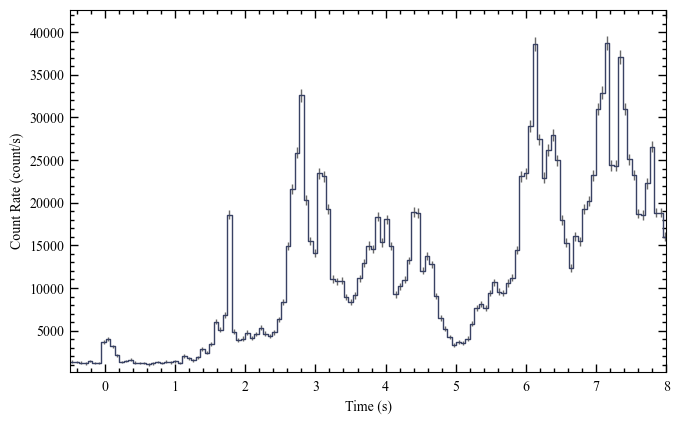

In [154]:
tte = TTE.open(fn_tte)
# bin to 2.048 s resolution, reference time is trigger time (coarse resolution to accurately model the bkg)
binsize = 0.064 # 4ms binning

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time, binsize) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (-0.5,8)

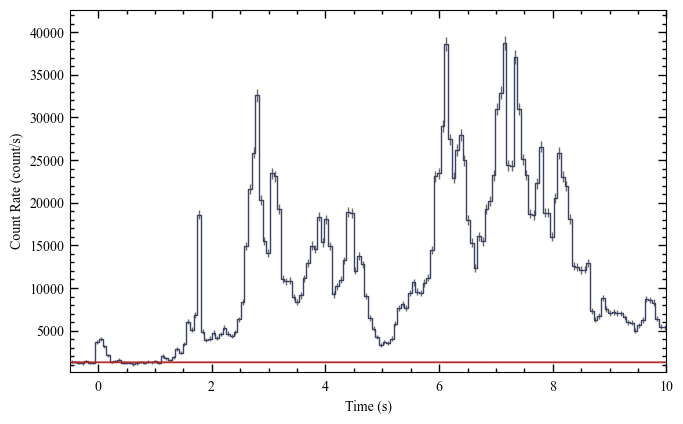

In [155]:
# Fit background
bkgd_times = [(-100.0, -50.0), (150,200)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
#type(bkgd)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-0.5,10)
lcplot.xlim = view_range

Normalised residuals: mean= 0.0011  std= 0.995
NormaltestResult(statistic=2.012437681453726, pvalue=0.36559875647779677)


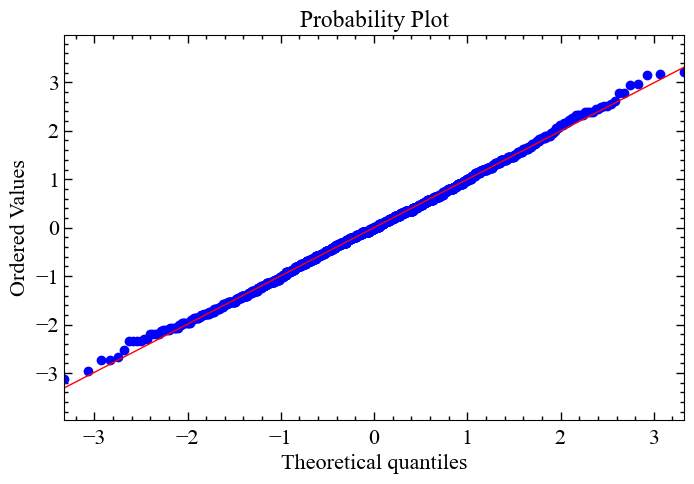

In [156]:
# Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).
backfitter.statistic/backfitter.dof
# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]

if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))

#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

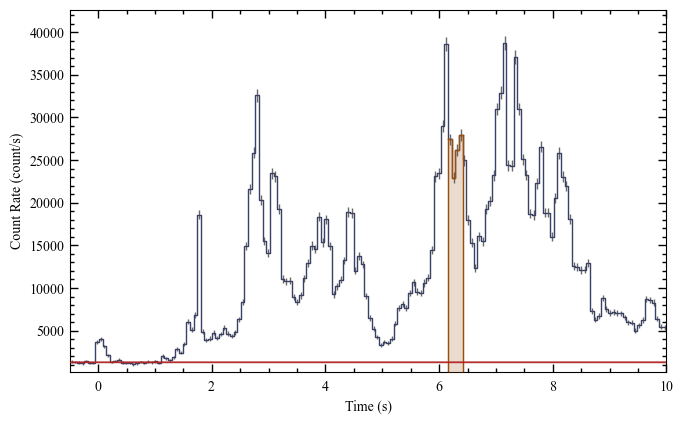

In [160]:
# Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.
# our lightcurve source selection
src_time = I[1]
time_selection = src_time


src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range
plt.show()

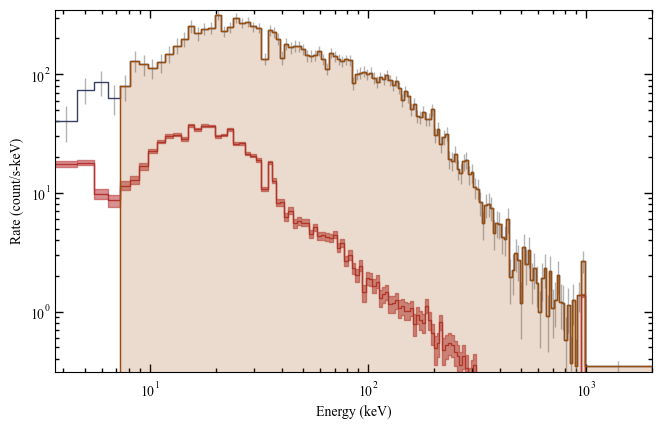

In [161]:
#spec_data = tte.to_spectrum(time_range=(-0.5,10))
spec_data = phaii.to_spectrum(time_range=src_time)

# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)

# and the energy range selection that was made
spec_selection = phaii.to_spectrum(time_range=time_selection, energy_range=erange)

specplot = Spectrum(data=spec_data, background=spec_bkgd)
specplot.add_selection(spec_selection)
plt.show()

In [162]:
GRB_id = 'FERMI_GRB211211A'
pha = tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB211211A_na.rsp FERMI_GRB211211A_na.pha+2 RESPFILE


# FERMI fits interval extraction

## Notes
    -Allegedly we have thermal and non-thermal emission from GRB 211211A
    -Therefore we need at least two models; one for each type
    -Backbody (BB) or Plack for the thermal emission.
    -Band (ngrbep) for non-thermal
    -Paper suggest (2SBPL + BB)
    
    -one possible physical interpretation of thermal and non-thermal emissions in GRB 211211A is from the contributions of 
    both ν ν̄ annihilation and the Blandford-Znajek mechanisms in the relativistic jet when a stellar mass
    black hole resides in the central engine.